In [6]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from typing import List
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
# hyperparameters

n_classes = 3
n_clusters = 3
n_epochs = 10
n_supervised_obs = 100
unsupervised_importance = 0.001

In [8]:
def load_data(data_file: str):
    """
    code provided by ujjwal
    """
    data = np.load(data_file)
    features = data['features']
    labels = data['labels']
    labels = np.expand_dims(labels, axis=-1)
    data = np.concatenate((features, labels), axis=1)
    df = pd.DataFrame(data, columns=['body_mass', 'culmen_depth', 'culmen_length', 'flipper_length', 'species'])
    df.sample(frac=1)
    return df

In [9]:
def get_cluster_labels(y_train: torch.Tensor,
                       cluster_assignments: torch.Tensor,
                       cluster_assignments_labeled_train: torch.Tensor,
                       n_clusters: int):
    cluster_labels = torch.zeros(size=cluster_assignments.shape)
    for cluster_id in range(n_clusters):
        cluster_label = torch.mode(input=y_train[cluster_assignments_labeled_train == cluster_id])[0].int()
        cluster_labels[cluster_assignments == cluster_id] = cluster_label
    return cluster_labels


def plot_2d(cluster_labels_unsupervised: torch.Tensor,
            cluster_labels_supervised: torch.Tensor,
            x_unsupervised: torch.Tensor,
            x_supervised: torch.Tensor,
            y_supervised: torch.Tensor,
            n_classes: int,
            colors: List[str],
            title: str):

    # unsupervised with low alpha
    for class_id in range(n_classes):
        plt.scatter(x=x_unsupervised[cluster_labels_unsupervised == class_id][:, 0],
                    y=x_unsupervised[cluster_labels_unsupervised == class_id][:, 1],
                    c=colors[class_id],
                    s=50,
                    alpha=0.3,
                    label="unsupervised preds")

    # supervised small with high alpha
    for class_id in range(n_classes):
        plt.scatter(x=x_supervised[cluster_labels_supervised == class_id][:, 0],
                    y=x_supervised[cluster_labels_supervised == class_id][:, 1],
                    c=colors[class_id],
                    s=50,
                    alpha=0.8,
                    label="supervised preds")

    # circle in color of ground truth class around false classified supervised points
    for class_id in range(n_classes):
        # mask_final: should have been classified as class_id, but got other pred
        mask1 = cluster_labels_supervised != class_id  # pred != class_id
        mask2 = y_supervised == class_id  # target == class_id
        mask_final = (mask1.int() + mask2.int()) == 2
        plt.scatter(x=x_supervised[mask_final][:, 0],
                    y=x_supervised[mask_final][:, 1],
                    facecolors="none",
                    s=50,
                    edgecolors=colors[class_id],
                    label="ground truth")

    # hide tick(label)s
    plt.tick_params(axis='both',
                    which='both',
                    bottom=False,
                    top=False,
                    left=False,
                    right=False,
                    labelbottom=False,
                    labeltop=False,
                    labelleft=False,
                    labelright=False)
    plt.title(title)
    handles, labels = plt.gca().get_legend_handles_labels()
    plt.legend(handles=[handles[0], handles[3], handles[6]], labels=[labels[0], labels[3], labels[6]])
    plt.tight_layout()
    plt.show()


def j_unsupervised(cluster_centers: torch.Tensor, cluster_assignments: torch.Tensor, x: torch.Tensor):
    loss = 0
    for cluster_id in range(len(cluster_centers)):
        cluster_center = torch.unsqueeze(cluster_centers[cluster_id], dim=0)
        for obs in x[cluster_assignments == cluster_id]:
            loss += torch.cdist(x1=torch.unsqueeze(obs, dim=0).float(), x2=cluster_center, p=2)
    return loss


def j_supervised(cluster_centers: torch.Tensor,
                 cluster_assignments_labeled: torch.Tensor,
                 y: torch.Tensor,
                 n_classes: int):
    loss = 0
    n = len(cluster_assignments_labeled)
    for k in range(len(cluster_centers)):
        cluster_members = (cluster_assignments_labeled == k).int()
        n_k = torch.sum(cluster_members)
        sum_inner = 0
        for c in range(n_classes):  # for all classes
            class_members = (y == c).int()
            c_in_k = torch.sum((cluster_members + class_members) == 2)
            c_in_k_relative = c_in_k / n_k
            sum_inner += c_in_k_relative**2
        loss += (n_k / n) * (1 - sum_inner)
    return loss


def j(cluster_centers: torch.Tensor, cluster_assignments: torch.Tensor, x: torch.Tensor, y: torch.Tensor, cluster_assignments_labeled: torch.Tensor, unsupervised_importance: float):
    loss_unsupervised = j_unsupervised(cluster_centers=cluster_centers,
                                       cluster_assignments=cluster_assignments,
                                       x=x)

    loss_supervised = j_supervised(cluster_centers=cluster_centers,
                                   cluster_assignments_labeled=cluster_assignments_labeled,
                                   y=y,
                                   n_classes=n_classes)
    return loss_supervised + unsupervised_importance * loss_unsupervised


def assign_to_cluster(x: torch.Tensor, cluster_centers: torch.Tensor):
    clusters = [[], [], []]
    cluster_assignments = torch.zeros(size=[len(x)])
    for i, obs in enumerate(x):
        obs = torch.unsqueeze(obs, dim=0).float()
        dists = torch.zeros(size=[3])
        for j, cluster_center in enumerate(cluster_centers):
            cluster_center = torch.unsqueeze(cluster_center, dim=0)
            dists[j] = (torch.cdist(x1=obs, x2=cluster_center, p=2))  # euclidian dist.
        cluster_assignments[i] = torch.argmin(input=dists)
        clusters[torch.argmin(dists)].append(obs)
    return cluster_assignments, [torch.cat(cluster) for cluster in clusters]


def adjust_cluster_centers(clusters: List[torch.Tensor]):
    return torch.vstack([torch.mean(cluster, dim=0) for cluster in clusters])

# with 2 features for visual interpretation

In [10]:
n_feats = 2

df = load_data(data_file="/content/drive/MyDrive/semi_supervised_clustering/data_penguins.npz")
x = torch.tensor(df.values[:, :(n_feats)])
x_train = x[:300]
x_train_labeled = x[:n_supervised_obs]
x_val = x[300:]

y = torch.tensor(df.values[:, -1])
y_train_labeled = y[:n_supervised_obs]
y_val = y[300:]


# algorithm
losses_before_supervised_step = []
losses_after_supervised_step = []
# 0. init cluster centers
cluster_centers = torch.rand(size=[3, n_feats])  # 3 classes, 4 features

for i in range(n_epochs):
    print("epoch", i + 1)
    # 1. unsupervised: assign data points to most similar cluster center
    cluster_assignments_train, clusters = assign_to_cluster(x=x_train, cluster_centers=cluster_centers)
    losses_before_supervised_step.append(j(cluster_centers=cluster_centers,
                                           cluster_assignments=cluster_assignments_train,
                                           x=x_train,
                                           y=y_train_labeled,
                                           cluster_assignments_labeled=cluster_assignments_train[:n_supervised_obs],
                                           unsupervised_importance=unsupervised_importance))

    # 2. supervised: move labeled point to other cluster if that minimizes objective function
    for labeled_obs_id in range(n_supervised_obs):
        candidate_losses = torch.zeros(size=[n_clusters])
        for cluster_id in range(n_clusters):
            cluster_assignments_train[labeled_obs_id] = cluster_id
            candidate_losses[cluster_id] = j(cluster_centers=cluster_centers,
                                             cluster_assignments=cluster_assignments_train,
                                             x=x_train,
                                             y=y_train_labeled,
                                             cluster_assignments_labeled=cluster_assignments_train[:n_supervised_obs],
                                             unsupervised_importance=unsupervised_importance)
        cluster_assignments_train[labeled_obs_id] = torch.argmin(candidate_losses)
    losses_after_supervised_step.append(j(cluster_centers=cluster_centers,
                                          cluster_assignments=cluster_assignments_train,
                                          x=x_train,
                                          y=y_train_labeled,
                                          cluster_assignments_labeled=cluster_assignments_train[:n_supervised_obs],
                                          unsupervised_importance=unsupervised_importance))

    # 3. based on unsupervised and supervised criteria: cluster centers = mean(cluster)
    cluster_centers = adjust_cluster_centers(clusters=clusters)

# 4. final assignments
cluster_assignments_train, _ = assign_to_cluster(x=x_train, cluster_centers=cluster_centers)
cluster_assignments_val, _ = assign_to_cluster(x=x_val, cluster_centers=cluster_centers)

epoch 1
epoch 2
epoch 3
epoch 4
epoch 5
epoch 6
epoch 7
epoch 8
epoch 9
epoch 10


In [11]:
cluster_labels_train = get_cluster_labels(y_train=y_train_labeled,
                                          cluster_assignments=cluster_assignments_train,
                                          cluster_assignments_labeled_train=cluster_assignments_train[:n_supervised_obs],
                                          n_clusters=3)

cluster_labels_val = get_cluster_labels(y_train=y_train_labeled,
                                        cluster_assignments=cluster_assignments_val,
                                        cluster_assignments_labeled_train=cluster_assignments_train[:n_supervised_obs],
                                        n_clusters=3)



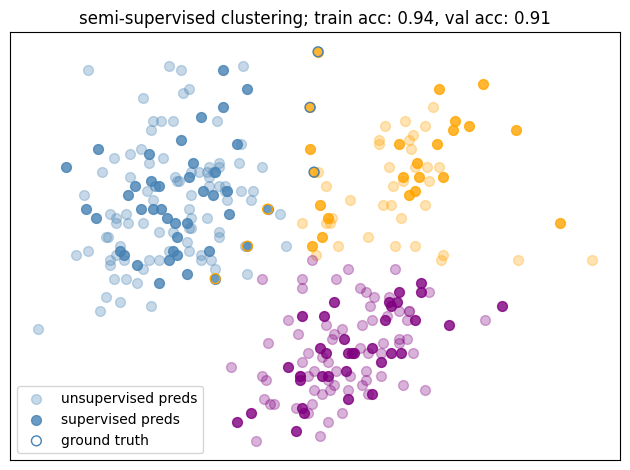

In [12]:
# plot 2d results on training set
acc_train = round((torch.sum(cluster_labels_train[:n_supervised_obs] == y_train_labeled) / len(y_train_labeled)).item(), 2)
acc_val = round((torch.sum(cluster_labels_val == y_val) / len(y_val)).item(), 2)
plot_2d(cluster_labels_supervised=cluster_labels_train[:n_supervised_obs],
        cluster_labels_unsupervised=cluster_labels_train[n_supervised_obs:],
        x_supervised=x_train[:n_supervised_obs],
        x_unsupervised=x_train[n_supervised_obs:],
        y_supervised=y_train_labeled,
        n_classes=n_classes,
        colors=["steelblue", "orange", "purple"],
        title=f"semi-supervised clustering; train acc: {acc_train}, val acc: {acc_val}")

/usr/local/lib/python3.10/dist-packages/numpy/core/shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
/usr/local/lib/python3.10/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


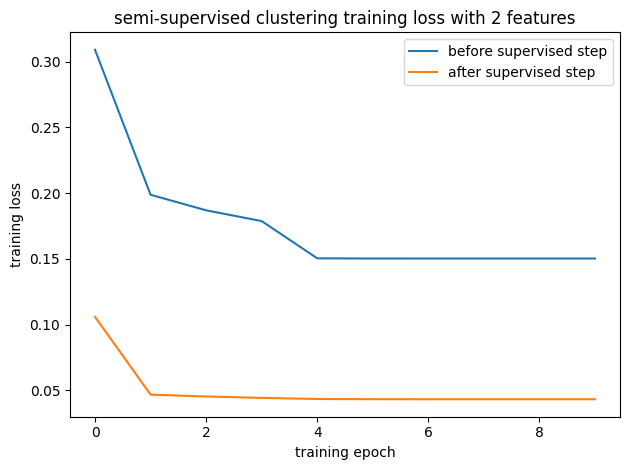

In [13]:
# plot losses
plt.clf()
plt.plot(torch.arange(n_epochs), losses_before_supervised_step, label="before supervised step")
plt.plot(torch.arange(n_epochs), losses_after_supervised_step, label="after supervised step")
plt.title("semi-supervised clustering training loss with 2 features")
plt.ylabel("training loss")
plt.xlabel("training epoch")
plt.legend()
plt.tight_layout()
plt.show()

# with all 4 features

In [15]:
n_feats = 4

x = torch.tensor(df.values[:, :(n_feats)])
x_train = x[:300]
x_train_labeled = x[:n_supervised_obs]
x_val = x[300:]

y = torch.tensor(df.values[:, -1])
y_train_labeled = y[:n_supervised_obs]
y_val = y[300:]


# algorithm
losses_before_supervised_step = []
losses_after_supervised_step = []
# 0. init cluster centers
cluster_centers = torch.rand(size=[3, n_feats])

for i in range(n_epochs):
    print("epoch", i + 1)
    # 1. unsupervised: assign data points to most similar cluster center
    cluster_assignments_train, clusters = assign_to_cluster(x=x_train, cluster_centers=cluster_centers)
    losses_before_supervised_step.append(j(cluster_centers=cluster_centers,
                                           cluster_assignments=cluster_assignments_train,
                                           x=x_train,
                                           y=y_train_labeled,
                                           cluster_assignments_labeled=cluster_assignments_train[:n_supervised_obs],
                                           unsupervised_importance=unsupervised_importance))

    # 2. supervised: move labeled point to other cluster if that minimizes objective function
    for labeled_obs_id in range(n_supervised_obs):
        candidate_losses = torch.zeros(size=[n_clusters])
        for cluster_id in range(n_clusters):
            cluster_assignments_train[labeled_obs_id] = cluster_id
            candidate_losses[cluster_id] = j(cluster_centers=cluster_centers,
                                             cluster_assignments=cluster_assignments_train,
                                             x=x_train,
                                             y=y_train_labeled,
                                             cluster_assignments_labeled=cluster_assignments_train[:n_supervised_obs],
                                             unsupervised_importance=unsupervised_importance)
        cluster_assignments_train[labeled_obs_id] = torch.argmin(candidate_losses)
    losses_after_supervised_step.append(j(cluster_centers=cluster_centers,
                                          cluster_assignments=cluster_assignments_train,
                                          x=x_train,
                                          y=y_train_labeled,
                                          cluster_assignments_labeled=cluster_assignments_train[:n_supervised_obs],
                                          unsupervised_importance=unsupervised_importance))

    # 3. based on unsupervised and supervised criteria: cluster centers = mean(cluster)
    cluster_centers = adjust_cluster_centers(clusters=clusters)

# 4. final assignments
cluster_assignments_train, _ = assign_to_cluster(x=x_train, cluster_centers=cluster_centers)
cluster_assignments_val, _ = assign_to_cluster(x=x_val, cluster_centers=cluster_centers)

epoch 1
epoch 2
epoch 3
epoch 4
epoch 5
epoch 6
epoch 7
epoch 8
epoch 9
epoch 10


In [16]:
cluster_labels_train = get_cluster_labels(y_train=y_train_labeled,
                                          cluster_assignments=cluster_assignments_train,
                                          cluster_assignments_labeled_train=cluster_assignments_train[:n_supervised_obs],
                                          n_clusters=3)

cluster_labels_val = get_cluster_labels(y_train=y_train_labeled,
                                        cluster_assignments=cluster_assignments_val,
                                        cluster_assignments_labeled_train=cluster_assignments_train[:n_supervised_obs],
                                        n_clusters=3)

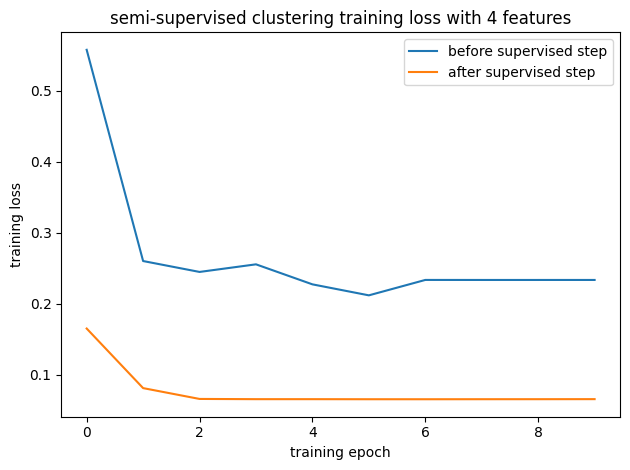

In [17]:
# plot losses
plt.clf()
plt.plot(torch.arange(n_epochs), losses_before_supervised_step, label="before supervised step")
plt.plot(torch.arange(n_epochs), losses_after_supervised_step, label="after supervised step")
plt.title("semi-supervised clustering training loss with 4 features")
plt.ylabel("training loss")
plt.xlabel("training epoch")
plt.legend()
plt.tight_layout()
plt.show()

In [18]:
acc_train = round((torch.sum(cluster_labels_train[:n_supervised_obs] == y_train_labeled) / len(y_train_labeled)).item(), 2)
acc_val = round((torch.sum(cluster_labels_val == y_val) / len(y_val)).item(), 2)
print("acc train:", acc_train)
print("acc val:", acc_val)

acc train: 0.89
acc val: 0.82
